## import, 설정값, 상수

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import glob
from typing import Dict, List, Tuple
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow import convert_to_tensor, expand_dims, float32
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random
import concurrent.futures
import threading
import gc

In [2]:
TARGET_SIZE = (224, 224)
NUM_GENRES = 11
BATCH_SIZE = 32
SAMPLES_PER_EPOCH_PER_GENRE = 10000
BASE_DIR = r'F:\ML\dataset'
SOURCE_DIR_NAME = 'Processed_224x224'
VALIDATION_DIR_NAME = 'Validation_Set'
GENRE_LIST: List[str] = [
    "Adventure", "Action", "RPG", "Strategy", "Simulation", "Sports", "Racing", 
    "Puzzle", "Sandbox", "Shooter", "Survival"
]
AUGMENTATION_GENRES = {}
THRESHOLD = 0.5

### 커스텀 지표 정의

In [3]:
import tensorflow as tf
from tensorflow.keras import backend as K

# --- 지표 임계값 설정 ---

def exact_match_ratio(y_true, y_pred):
    """
    완전성 지표 (Exact Match Ratio): 모든 레이블을 완벽하게 맞춘 비율
    """
    # 1. 예측값을 이진화 (0.5 임계값)
    y_pred_bin = K.cast(K.greater(y_pred, THRESHOLD), 'float32')
    
    # 2. 행별로 예측값과 실제값이 완벽하게 일치하는지 확인
    # K.all(K.equal(a, b), axis=1) -> True/False (1/0) 벡터 반환
    match = K.all(K.equal(y_true, y_pred_bin), axis=1)
    
    # 3. 일치하는 행의 평균 (전체 이미지 중 완벽 일치 비율)
    return K.mean(match)

def micro_f1_score(y_true, y_pred):
    """
    Micro F1-Score: 모든 레이블에 대한 TP, FP, FN을 합산하여 계산
    """
    # 1. 예측값을 이진화 (0.5 임계값)
    y_pred_bin = K.cast(K.greater(y_pred, THRESHOLD), 'float32')
    
    # 2. 총 TP, FP, FN 계산 (배치 전체에 대해 합산)
    TP = K.sum(y_true * y_pred_bin)
    FP = K.sum((1 - y_true) * y_pred_bin)
    FN = K.sum(y_true * (1 - y_pred_bin))
    
    # 3. Precision 및 Recall 계산
    precision = TP / (TP + FP + K.epsilon())
    recall = TP / (TP + FN + K.epsilon())
    
    # 4. F1-Score 계산
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1_score

def jaccard_similarity(y_true, y_pred):
    """
    Jaccard Similarity (Jaccard Index): (교집합 / 합집합)의 평균
    """
    # 1. 예측값을 이진화 (0.5 임계값)
    y_pred_bin = K.cast(K.greater(y_pred, THRESHOLD), 'float32')
    
    # 2. 교집합 (Intersection)과 합집합 (Union) 계산
    # Intersection: y_true * y_pred_bin (둘 다 1인 경우만 1)
    # Union: y_true + y_pred_bin - (y_true * y_pred_bin) (둘 중 하나라도 1인 경우만 1)
    
    intersection = K.sum(y_true * y_pred_bin, axis=1)
    union = K.sum(K.clip(y_true + y_pred_bin, 0, 1), axis=1)
    
    # 3. 행별 Jaccard Index 계산 (분모가 0이 되는 경우 방지)
    jaccard = intersection / (union + K.epsilon())
    
    # 4. 배치 전체의 평균 반환
    return K.mean(jaccard)

## CNN 모델 정의

In [4]:
# --- 모델 정의 ---
def build_cnn_model(input_shape: Tuple[int, int, int], num_genres: int):
    """VGG-style의 CNN 모델을 정의하고 컴파일합니다."""
    
    model = keras.Sequential([
        # 입력 레이어
        layers.Input(shape=input_shape),

        # 블록 1: 32 필터
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        
        # 블록 2: 64 필터
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),        
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),
        
        # 블록 3: 64 필터
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),                
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),        
        layers.MaxPooling2D((2, 2)),        
        layers.Dropout(0.2),

        # 블록 4: 128 필터
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        
        # 특징 추출 끝
        layers.GlobalAveragePooling2D(),

        layers.Dropout(0.3),
        
        # Dense 레이어
        layers.Dense(512, activation='relu'),

        # 출력 레이어: 다중 레이블 분류를 위해 시그모이드 사용
        layers.Dense(num_genres, activation='sigmoid')
    ])

    # 모델 컴파일: 다중 레이블에 적합한 손실 함수 및 지표 사용
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', # 이진 교차 엔트로피 사용
        metrics=[
            'accuracy',
            # 💡 요청하신 커스텀 지표 추가
            exact_match_ratio,
            micro_f1_score,
            jaccard_similarity,
            
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc'),
            # F1-Score는 Keras 기본 지표에 없어 커스텀 구현 필요 (여기선 생략)
        ]
    )
    return model

### 커스텀 데이터 증강 함수

In [5]:
def data_augmenter():
    """조건부로 적용될 데이터 증강 파이프라인을 정의합니다."""
    return keras.Sequential([
        layers.RandomFlip("horizontal"),  # 수평 뒤집기 (가장 흔함)
        layers.RandomRotation(0.1),        # 10% 범위 내에서 랜덤 회전
        layers.RandomZoom(0.1),           # 10% 범위 내에서 랜덤 줌
        layers.RandomContrast(0.2),       # 20% 범위 내에서 랜덤 대비 조절
    ], name='data_augmenter')

## 데이터 준비 함수

In [6]:
# BASE_DIR, SOURCE_DIR_NAME, VALIDATION_DIR_NAME, GENRE_LIST, SAMPLES_PER_EPOCH_PER_GENRE, AUGMENTATION_GENRES 등 CONSTANTS는 유지됩니다.

def create_tag_list_from_csv(csv_path: str, data_root_dir: str, genre_list: List[str], samples_per_genre: int) -> Tuple[List[str], List[np.ndarray], List[bool]]:
    """
    CSV에서 태그를 읽고, 장르별 샘플링 수에 맞춰 파일 경로, 태그 벡터 리스트를 생성합니다.
    """
    tag_df = pd.read_csv(csv_path).set_index('filename')
    
    # 1. 파일 경로 및 태그 벡터 매핑
    tag_vectors_map = {}
    filename_to_path = {}

    for filename, row in tag_df.iterrows():
        tag_vector = row[genre_list].values.astype(np.float32)
        
        genres_in_file = [g for g in genre_list if row[g] == 1]
        
        path_found = None
        # 파일 경로 탐색 (첫 번째 발견된 경로 사용)
        for tag in genres_in_file:
            path = os.path.join(data_root_dir, tag, filename)
            if os.path.exists(path):
                path_found = path
                break
        
        if path_found:
            filename_to_path[filename] = path_found
            tag_vectors_map[filename] = tag_vector
            
    # 2. 장르별 샘플링 및 증강 플래그 생성
    paths_list = []
    tags_list = []
    # **새로운 리스트:** 해당 샘플이 증강 대상인지 (Music 또는 Fighting) 여부를 저장
    is_augmented_list = [] 
    
    # 검증 데이터는 모든 파일을 한 번씩만 포함, 증강 없음
    print("🔍 검증 데이터: 모든 파일 경로 리스트 생성 중...")
    for filename, path in filename_to_path.items():
        paths_list.append(path)
        tags_list.append(tag_vectors_map[filename])
        is_augmented_list.append(False) # 검증 데이터는 증강하지 않음
        
    return paths_list, tags_list, is_augmented_list

## 데이터 매니저(경로 캐싱, 랜덤 샘플링)

In [7]:
class DataManager:
    def __init__(self, csv_path, data_root_dir, genre_list):
        # 처음 한 번만 실행: 파일 경로 및 태그 정보 캐싱
        self.genre_list = genre_list
        tag_df = pd.read_csv(csv_path).set_index('filename')
        
        self.tag_vectors_map = {}
        self.filename_to_path = {}
        self.genre_to_filenames = {genre: [] for genre in genre_list}

        print("🚚 데이터 매핑 정보를 로딩 중...")
        for filename, row in tag_df.iterrows():
            tag_vector = row[genre_list].values.astype(np.float32)
            
            # 실제 파일이 존재하는지 한 번만 확인
            path_found = None
            genres_in_file = [g for g in genre_list if row[g] == 1]
            for tag in genres_in_file:
                path = os.path.join(data_root_dir, tag, filename)
                if os.path.exists(path):
                    path_found = path
                    break
            
            if path_found:
                self.filename_to_path[filename] = path_found
                self.tag_vectors_map[filename] = tag_vector
                # 장르별로 파일 이름 미리 그룹화 (샘플링 속도 최적화)
                for tag in genres_in_file:
                    self.genre_to_filenames[tag].append(filename)

    def get_balanced_sample(self, samples_per_genre, augmentation_genres):
        """매 에폭마다 호출할 가벼운 샘플링 함수"""
        paths_list, tags_list, is_augmented_list = [], [], []

        for tag in self.genre_list:
            tag_filenames = self.genre_to_filenames[tag]
            if not tag_filenames: continue

            # Music, Fighting 등 증강 장르 처리
            if tag in augmentation_genres:
                selected = random.choices(tag_filenames, k=samples_per_genre)
                is_aug = True
            else:
                n_samples = len(tag_filenames)
                if n_samples >= samples_per_genre:
                    selected = random.sample(tag_filenames, k=samples_per_genre)
                else:
                    selected = tag_filenames
                is_aug = False
            
            for f in selected:
                paths_list.append(self.filename_to_path[f])
                tags_list.append(self.tag_vectors_map[f])
                is_augmented_list.append(is_aug)

        return paths_list, tags_list, is_augmented_list

## SSD 로드 함수

In [8]:
# data_augmenter 함수는 이제 사용하지 않습니다.

def load_and_preprocess_image(file_path, tag_vector, is_augmented: bool):
    """tf.data.Dataset의 map 함수에 사용될 I/O 및 조건부 증강 함수."""
    
    # 1. I/O (디스크에서 파일 읽기)
    img_raw = tf.io.read_file(file_path)
    img = tf.image.decode_image(img_raw, channels=3, expand_animations=False)
    img = tf.image.resize(img, TARGET_SIZE)
    
    # 2. 정규화 (float32로 변환)
    img = tf.cast(img, tf.float32) / 255.0
    
    # 3. 조건부 데이터 증강 (is_augmented=True 일 때만 적용)
    if is_augmented:
        # tf.cond를 사용하여 그래프 모드에서도 조건부 분기 처리 (필수)
        img = tf.cond(
            tf.equal(is_augmented, True), 
            lambda: apply_augmentation(img),
            lambda: img
        )
        
    return img, tag_vector

# 증강 로직을 tf.function으로 정의하여 retracing 문제 최소화
@tf.function
def apply_augmentation(img):
    # RandomFlip("horizontal")
    img = tf.image.random_flip_left_right(img) 
    
    # RandomRotation(0.1) - tf.image에 직접적인 대체 함수 없음, tf_addons 필요
    # tf.image.rot90 등으로 대체하거나, tf_addons 사용, 또는 tf.math.PI 기반의 tf.image.transform 사용
    # 여기서는 tf.image의 안정적인 함수만 사용합니다.
    
    # RandomContrast(0.2)
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2) # 1.0 +/- 0.2
    
    # NOTE: RandomZoom 및 RandomRotation이 필요하다면 tf.keras.layers 대신 
    # tf.image.affine_transform 또는 tf.image.transform을 사용하여 구현해야 합니다.
    # 현재는 안정적인 tf.image 함수만 사용하여 속도 및 안정성 보장합니다.
    
    return img

def create_dataset(paths_list, tags_list, is_augmented_list, batch_size: int, is_training: bool, num_parallel_calls: int = tf.data.AUTOTUNE):
    """
    파일 경로 및 태그 리스트를 사용하여 tf.data.Dataset 객체를 생성하고 최적화합니다.
    """
    
    # 1. 파일 경로 및 태그 리스트로 Dataset 생성
    dataset = tf.data.Dataset.from_tensor_slices((paths_list, tags_list))
    
    # 2. 훈련 시에는 무작위 섞기 (Shuffle)
    if is_training:
        dataset = dataset.shuffle(buffer_size=2048)
        
    # 3. 병렬 I/O 및 전처리 (핵심 속도 개선 부분!)
    # lambda를 사용하여 is_training 플래그를 load_and_preprocess_image에 전달
    dataset = dataset.map(
        lambda x, y: load_and_preprocess_image(x, y, is_training), 
        num_parallel_calls=num_parallel_calls # CPU 코어를 최대한 활용하도록 설정
    )
    
    # 4. 배치 처리 및 선반입
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

In [9]:
def plot_genre_confusion_matrices(y_true: np.ndarray, y_pred: np.ndarray, 
                                  genre_list: List[str] = GENRE_LIST, 
                                  threshold: float = THRESHOLD):
    """
    다중 레이블 분류 결과를 기반으로 각 장르별 2x2 Confusion Matrix를 계산하고 시각화합니다.

    Args:
        y_true: 실제 태그 벡터 (N_samples x N_genres), 값은 0 또는 1.
        y_pred: 모델의 예측 확률 (N_samples x N_genres), 값은 0.0 ~ 1.0.
        genre_list: 장르 이름 리스트.
        threshold: 이진 분류를 위한 임계값 (기본값 0.5).
    """
    
    # 예측 확률을 이진 값 (0 또는 1)으로 변환
    y_pred_bin = (y_pred >= threshold).astype(int)
    
    n_genres = len(genre_list)
    
    # 시각화를 위한 캔버스 설정 (예: 4행 4열로 최대 16개 장르 표시)
    rows = (n_genres + 3) // 4
    cols = 4
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten() # 1차원 배열로 평탄화하여 쉽게 접근

    print("-" * 50)
    print("📈 장르별 이진 Confusion Matrix 결과")
    print("-" * 50)
    
    for i, genre in enumerate(genre_list):
        # 1. 특정 장르에 대한 실제값과 예측값 추출
        y_true_genre = y_true[:, i]
        y_pred_genre = y_pred_bin[:, i]
        
        # 2. Confusion Matrix 계산 (sklearn 사용)
        # matrix: [[TN, FP], [FN, TP]]
        cm = confusion_matrix(y_true_genre, y_pred_genre)
        
        # 3. 데이터프레임 및 시각화
        cm_df = pd.DataFrame(cm, 
                             index=['F (0)', 'T (1)'], 
                             columns=['N (0)', 'P (1)'])
        
        # 4. 각 지표 값 추출 (TN, FP, FN, TP)
        TN, FP, FN, TP = cm.ravel()
        
        # 5. 콘솔 출력
        print(f"[{genre.upper()}]")
        print(f"  TP (올바르게 존재 예측): {TP:<6} | FN (놓침): {FN}")
        print(f"  FP (잘못 존재 예측): {FP:<6} | TN (올바르게 부재 예측): {TN}")
        print("-" * 20)
        
        # 6. Heatmap 시각화
        ax = axes[i]
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
        ax.set_title(f'{genre}', fontsize=14)
        ax.tick_params(axis='both', which='major', labelsize=10)
        
    # 사용하지 않는 서브플롯 숨기기
    for j in range(n_genres, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()
    print("-" * 50)

### 학습 함수

In [10]:
def train_model(epochs: int, batch_size: int):
    """
    tf.data.Dataset 파이프라인을 사용하여 모델 구축 및 학습을 수행합니다.
    """
    
    global BATCH_SIZE  # 전역 BATCH_SIZE를 인수로 받은 값으로 설정
    BATCH_SIZE = batch_size     

    # 데이터 매니저 초기화
    train_manager = DataManager(
        csv_path=os.path.join(BASE_DIR, 'training_tag_vectors.csv'),
        data_root_dir=os.path.join(BASE_DIR, SOURCE_DIR_NAME),
        genre_list=GENRE_LIST
    )
    
    # --- 검증 데이터셋 준비 ---
    val_paths, val_tags, val_is_augmented = create_tag_list_from_csv(
        csv_path=os.path.join(BASE_DIR, 'validation_tag_vectors.csv'),
        data_root_dir=os.path.join(BASE_DIR, VALIDATION_DIR_NAME),
        genre_list=GENRE_LIST, 
        samples_per_genre=0
    )
    val_dataset = create_dataset(val_paths, val_tags, val_is_augmented, BATCH_SIZE, is_training=False)
    
    df_val = pd.DataFrame(
        data=np.array(val_tags), 
        columns=GENRE_LIST
    )
    df_val['filename'] = [os.path.basename(p) for p in val_paths]

    print(f"✅ 검증 데이터 준비 완료. 총 샘플 수: {len(val_paths)}. 검증 스텝 수: {len(val_paths) // BATCH_SIZE + 1}")
    print("========================================\n")


    # 모델 구축 및 학습
    print("===== 2. CNN 모델 구축 및 학습 시작 =====")
    cnn_model = build_cnn_model(input_shape=(*TARGET_SIZE, 3), num_genres=NUM_GENRES)

    final_history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    
    print(f"===== 에폭별 랜덤 샘플링 학습 시작 (총 {epochs} 에폭) =====")
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        
        # [핵심] 매 에폭마다 카테고리별로 동일 수만큼 새로 샘플링
        train_paths, train_tags, train_is_augmented = train_manager.get_balanced_sample(
            samples_per_genre=SAMPLES_PER_EPOCH_PER_GENRE,
            augmentation_genres=AUGMENTATION_GENRES
        )
        
        # 매 에폭 새로운 데이터셋 인스턴스 생성
        train_dataset = create_dataset(train_paths, train_tags, train_is_augmented, BATCH_SIZE, is_training=True)
        
        # 2. 학습
        h = cnn_model.fit(train_dataset, epochs=1, validation_data=val_dataset)
        
        # 3. 기록 기록
        for key in final_history:
            final_history[key].append(h.history[key][0])
    print("========================================\n")

    # 모델, 기록, 검증 데이터프레임, 검증 데이터셋을 반환
    return cnn_model, final_history, df_val, val_dataset

### 시각화 함수, 컨퓨전 매트릭스

In [11]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import History
from typing import List

# 💡 앞서 정의한 커스텀 지표의 이름
METRIC_NAMES: List[str] = [
    'exact_match_ratio', 
    'micro_f1_score', 
    'jaccard_similarity'
]

def plot_loss_curve(history: keras.callbacks.History):
    """Keras History 객체에서 손실(loss) 곡선을 시각화합니다."""
    plt.figure(figsize=(8, 5))
    plt.plot(history['loss'], label='Training Loss')
    if 'val_loss' in history:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy_curve(history: keras.callbacks.History):
    """Keras History 객체에서 정확도(accuracy) 곡선을 시각화합니다."""
    plt.figure(figsize=(8, 5))
    plt.plot(history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history:
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# NOTE: plot_confusion_matrix_binary는 기존 plot_genre_confusion_matrices를 
#       호출하고 인수를 단순화합니다.
def plot_confusion_matrix_binary(model, df_val, val_generator, class_names: List[str]):
    """
    모델 예측 및 검증 데이터프레임을 사용하여 장르별 이진 Confusion Matrix를 출력합니다.
    """
    print("⏳ Confusion Matrix 생성을 위해 검증 데이터 예측값 계산 중...")
    y_pred_prob = model.predict(val_generator, steps=len(val_generator), verbose=0)
    
    # y_true_val 획득 (GENRE_LIST는 전역 상수 사용)
    y_true_val = df_val[GENRE_LIST].values

    # 기존 함수 호출 (GENRE_LIST는 전역 상수를 사용)
    plot_genre_confusion_matrices(y_true=y_true_val, y_pred=y_pred_prob, genre_list=GENRE_LIST)
    
    # NOTE: class_names 인수는 현재 장르별 매트릭스 출력 로직에서는 사용되지 않습니다.

## 실행 로직

In [12]:
# [1] 모델 학습 및 객체 반환
# -----------------------------------------------------------
# train_model의 인수는 epochs와 batch_size만 받도록 수정
model, model_history, df_val_for_eval, val_generator_for_eval = train_model(epochs=30, batch_size=32)

🚚 데이터 매핑 정보를 로딩 중...
🔍 검증 데이터: 모든 파일 경로 리스트 생성 중...
✅ 검증 데이터 준비 완료. 총 샘플 수: 33000. 검증 스텝 수: 1032

===== 2. CNN 모델 구축 및 학습 시작 =====
===== 에폭별 랜덤 샘플링 학습 시작 (총 30 에폭) =====

Epoch 1/30
3438/3438 [==============================] - 350s 100ms/step - loss: 0.4246 - accuracy: 0.2386 - exact_match_ratio: 0.1105 - micro_f1_score: 0.6054 - jaccard_similarity: 0.4850 - precision: 0.7576 - recall: 0.5103 - auc: 0.8393 - val_loss: 0.8975 - val_accuracy: 0.0011 - val_exact_match_ratio: 0.0113 - val_micro_f1_score: 0.3815 - val_jaccard_similarity: 0.2618 - val_precision: 0.4117 - val_recall: 0.3903 - val_auc: 0.6480

Epoch 2/30
3438/3438 [==============================] - 342s 100ms/step - loss: 0.4150 - accuracy: 0.2408 - exact_match_ratio: 0.1220 - micro_f1_score: 0.6204 - jaccard_similarity: 0.4999 - precision: 0.7598 - recall: 0.5290 - auc: 0.8490 - val_loss: 0.8672 - val_accuracy: 0.0011 - val_exact_match_ratio: 0.0119 - val_micro_f1_score: 0.3817 - val_jaccard_similarity: 0.2681 - val_precision

In [13]:
# [2] 모델 컴파일 정보 출력 (선택 사항: 학습 후 컴파일을 다시 할 필요는 없음)
# -----------------------------------------------------------
# NOTE: 모델은 train_model 내부에서 이미 컴파일 되었으므로, 이 호출은 불필요하지만
#       요청 형식에 맞추어 summary만 호출합니다.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                        

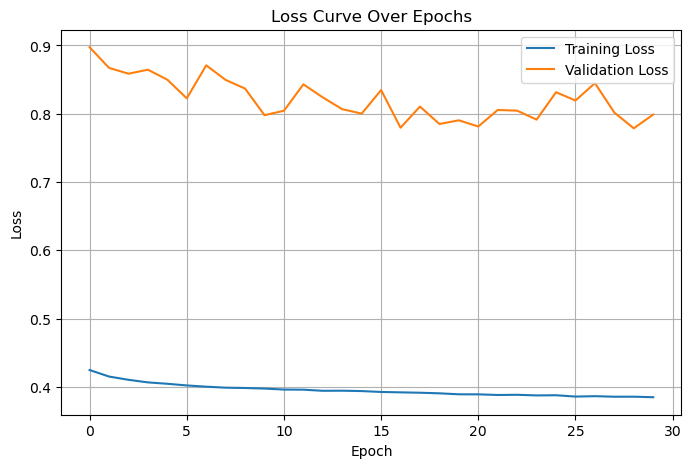

In [14]:
# [3] 손실 함수 표현
# -----------------------------------------------------------
plot_loss_curve(model_history)

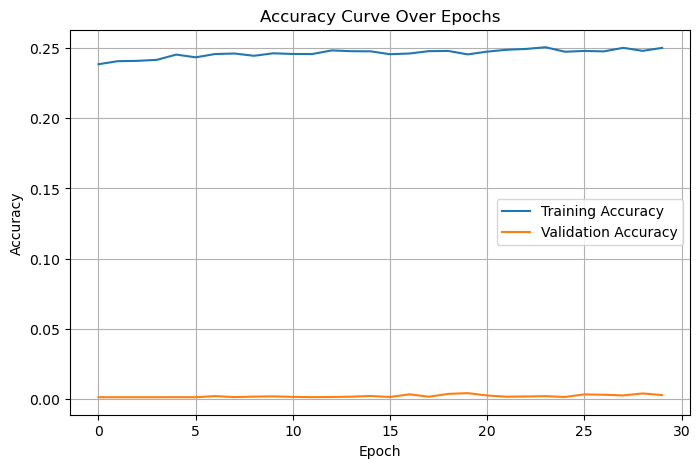

In [15]:
# [4] 정확도 함수 표현
# -----------------------------------------------------------
plot_accuracy_curve(model_history)

⏳ Confusion Matrix 생성을 위해 검증 데이터 예측값 계산 중...
--------------------------------------------------
📈 장르별 이진 Confusion Matrix 결과
--------------------------------------------------
[ADVENTURE]
  TP (올바르게 존재 예측): 12446  | FN (놓침): 2647
  FP (잘못 존재 예측): 10631  | TN (올바르게 부재 예측): 7276
--------------------
[ACTION]
  TP (올바르게 존재 예측): 15013  | FN (놓침): 2744
  FP (잘못 존재 예측): 8362   | TN (올바르게 부재 예측): 6881
--------------------
[RPG]
  TP (올바르게 존재 예측): 1707   | FN (놓침): 6656
  FP (잘못 존재 예측): 1056   | TN (올바르게 부재 예측): 23581
--------------------
[STRATEGY]
  TP (올바르게 존재 예측): 2935   | FN (놓침): 6753
  FP (잘못 존재 예측): 1245   | TN (올바르게 부재 예측): 22067
--------------------
[SIMULATION]
  TP (올바르게 존재 예측): 3081   | FN (놓침): 9298
  FP (잘못 존재 예측): 1699   | TN (올바르게 부재 예측): 18922
--------------------
[SPORTS]
  TP (올바르게 존재 예측): 112    | FN (놓침): 5002
  FP (잘못 존재 예측): 8      | TN (올바르게 부재 예측): 27878
--------------------
[RACING]
  TP (올바르게 존재 예측): 209    | FN (놓침): 4573
  FP (잘못 존재 예측): 9      | TN (올바르게 부재 예측): 

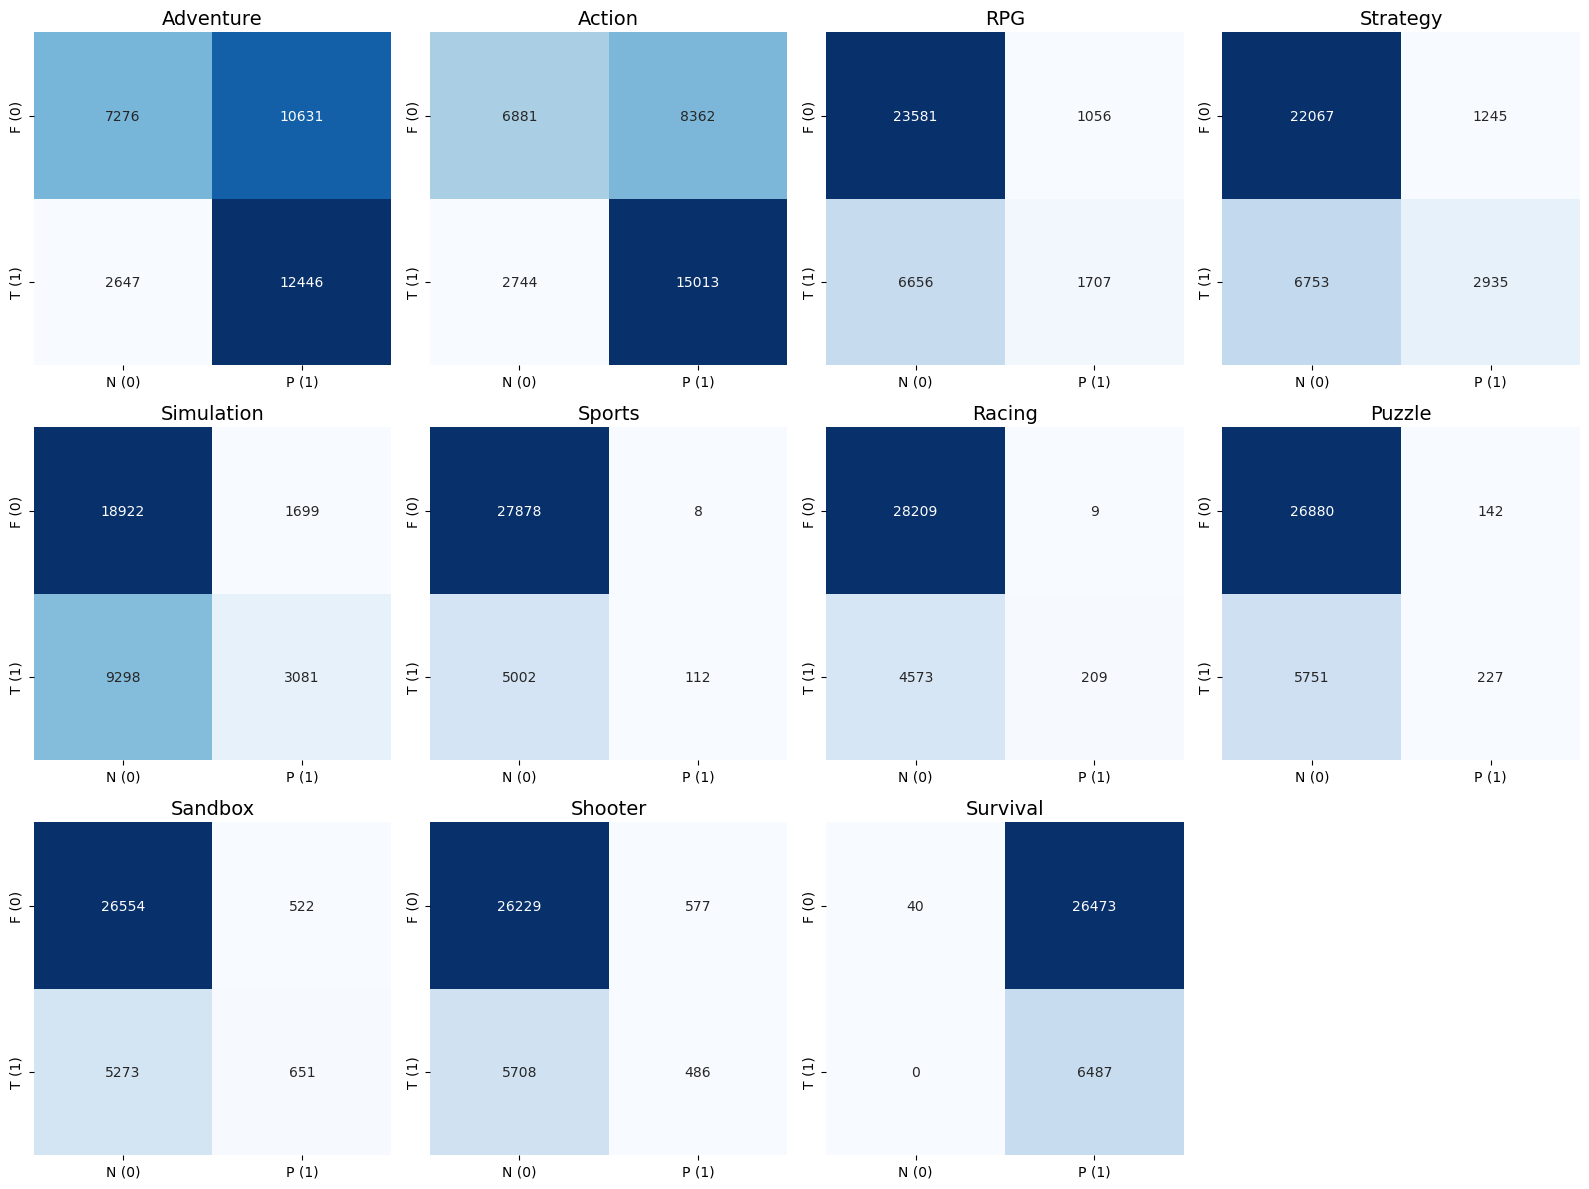

--------------------------------------------------


In [17]:
# [5] 컨퓨전 매트릭스 표현
# -----------------------------------------------------------
# NOTE: test_data 대신 학습 과정에서 반환된 df_val_for_eval과 val_generator_for_eval을 사용합니다.
plot_confusion_matrix_binary(
    model, 
    df_val_for_eval, 
    val_generator_for_eval, 
    class_names=['부재', '존재'] # 이 인수는 현재 장르별 로직에서 사용되지 않지만 형식 유지를 위해 남겨둡니다.
)

⏳ Confusion Matrix 생성을 위해 검증 데이터 예측값 계산 중...
--------------------------------------------------
📈 장르별 이진 Confusion Matrix 결과
--------------------------------------------------
[ADVENTURE]
  TP (올바르게 존재 예측): 12446  | FN (놓침): 2647
  FP (잘못 존재 예측): 10631  | TN (올바르게 부재 예측): 7276
--------------------
[ACTION]
  TP (올바르게 존재 예측): 15013  | FN (놓침): 2744
  FP (잘못 존재 예측): 8362   | TN (올바르게 부재 예측): 6881
--------------------
[RPG]
  TP (올바르게 존재 예측): 1707   | FN (놓침): 6656
  FP (잘못 존재 예측): 1056   | TN (올바르게 부재 예측): 23581
--------------------
[STRATEGY]
  TP (올바르게 존재 예측): 2935   | FN (놓침): 6753
  FP (잘못 존재 예측): 1245   | TN (올바르게 부재 예측): 22067
--------------------
[SIMULATION]
  TP (올바르게 존재 예측): 3081   | FN (놓침): 9298
  FP (잘못 존재 예측): 1699   | TN (올바르게 부재 예측): 18922
--------------------
[SPORTS]
  TP (올바르게 존재 예측): 112    | FN (놓침): 5002
  FP (잘못 존재 예측): 8      | TN (올바르게 부재 예측): 27878
--------------------
[RACING]
  TP (올바르게 존재 예측): 209    | FN (놓침): 4573
  FP (잘못 존재 예측): 9      | TN (올바르게 부재 예측): 

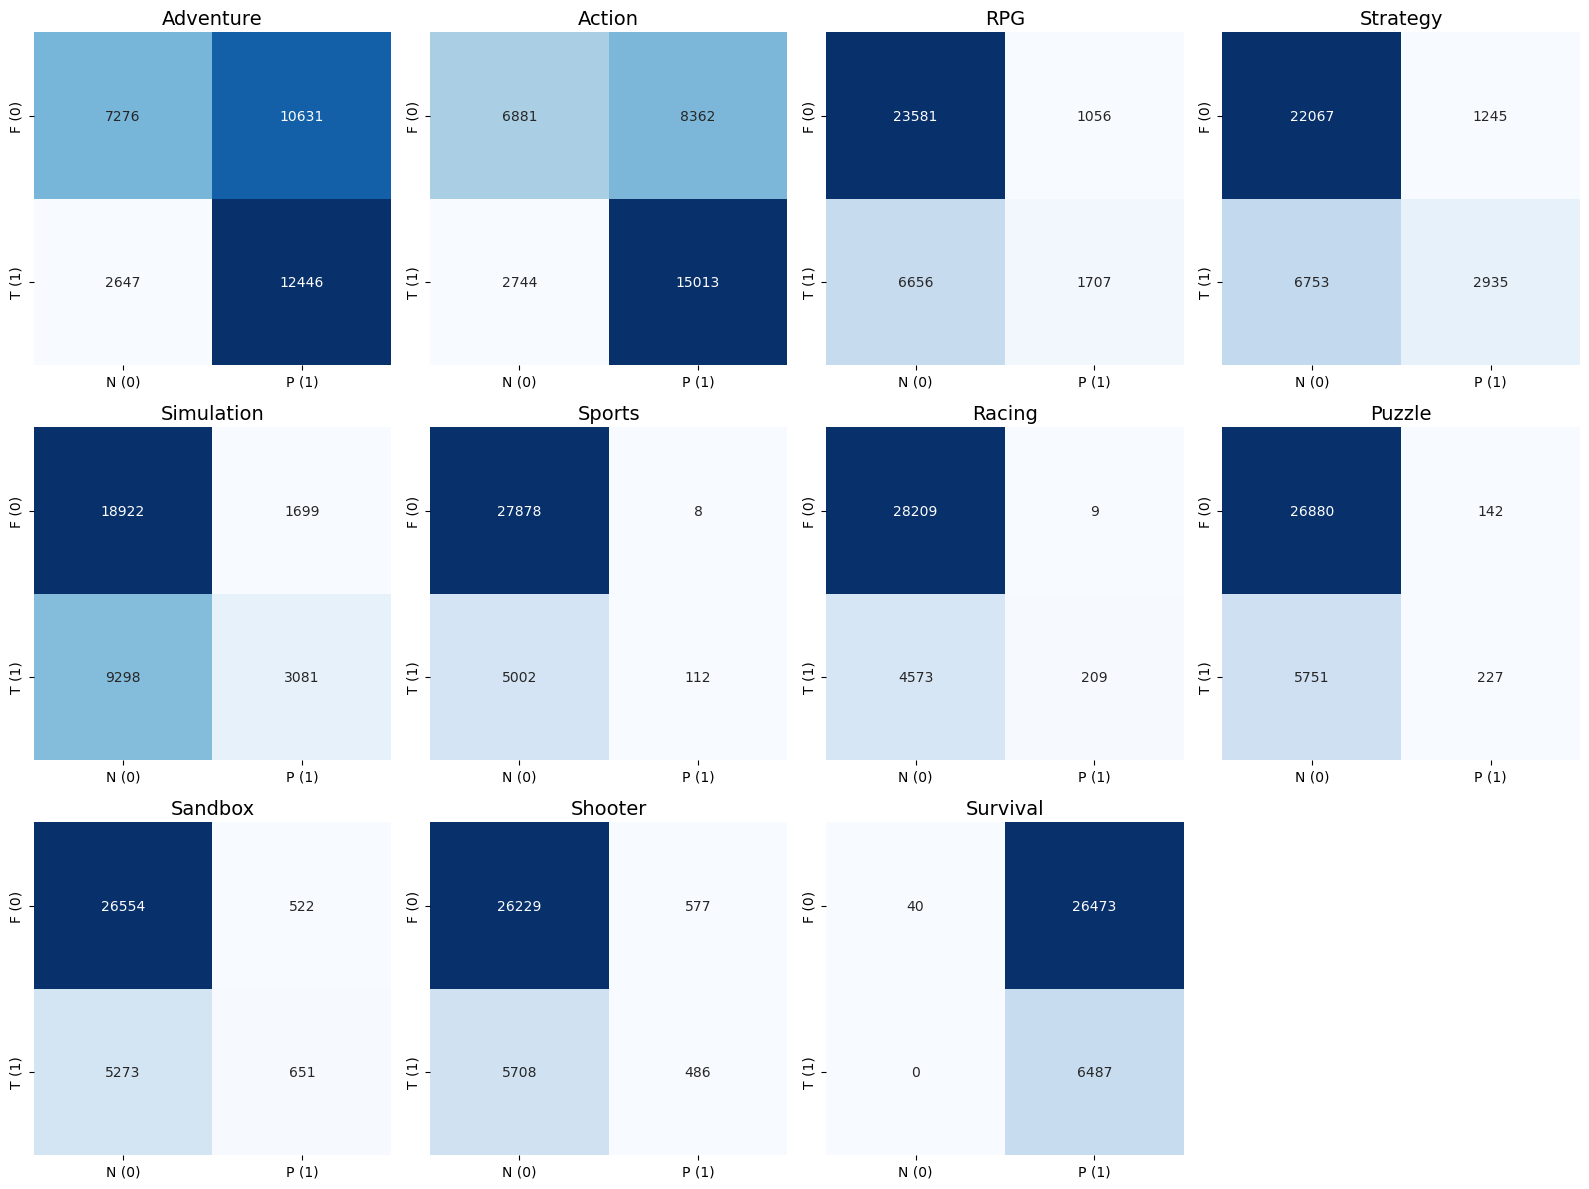

--------------------------------------------------
